In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

Importation du csv dans un dataframe

In [2]:
df_ = pd.read_csv('../dataset/rfm_filtered.csv', index_col='Customer ID')
df = df_.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 12346 to 18287
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TotalInvoices           5820 non-null   int64  
 1   TotalQuantity           5820 non-null   int64  
 2   TotalPrice              5820 non-null   float64
 3   Recency                 5820 non-null   int64  
 4   CancellationPercentage  5820 non-null   float64
 5   AvgItemsPerOrder        5820 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 318.3 KB


### Normalisation des données

In [4]:
from sklearn.preprocessing import StandardScaler

# Normaliser les valeurs RFM
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(df)

### Nombre de clusters : méthode du coude

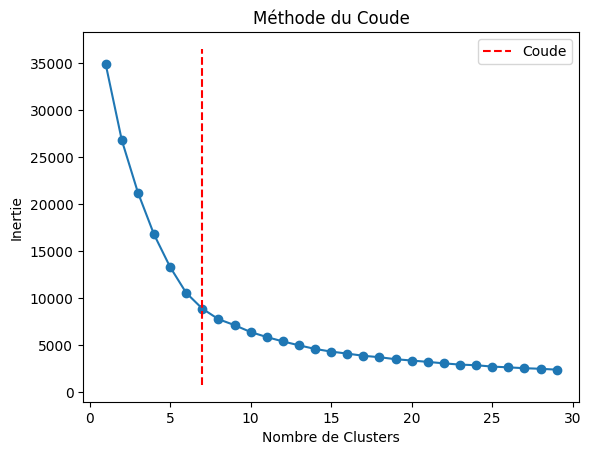

Nombre de clusters détecté: 7


In [5]:
from kneed import KneeLocator

inertias = []

for n_clusters in range(1, 30):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)

knee = KneeLocator(range(1, 30), inertias, curve="convex", direction="decreasing")

plt.plot(range(1, 30), inertias, marker='o')
plt.title("Méthode du Coude")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Inertie")
plt.vlines(knee.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r', label='Coude')
plt.legend()
plt.show()

print("Nombre de clusters détecté:", knee.elbow)

### Application du clustering (avec K-means)

In [6]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(rfm_normalized)

### Réduction de dimension avec T-SNE

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(rfm_normalized)

### Visualisation des clusters ave T-SNE

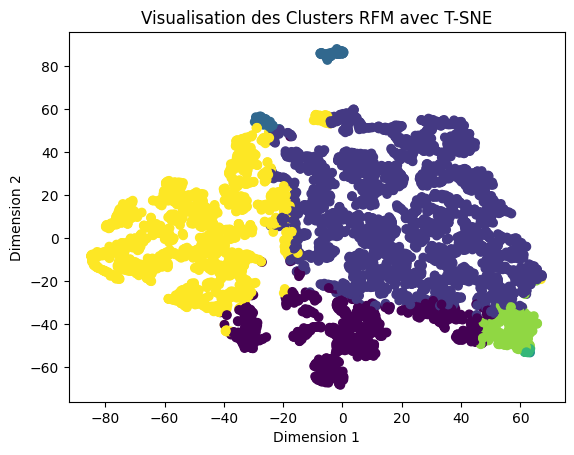

In [8]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=clusters, cmap="viridis")
plt.title("Visualisation des Clusters RFM avec T-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


## PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
pca_data = pca.fit_transform(rfm_normalized)

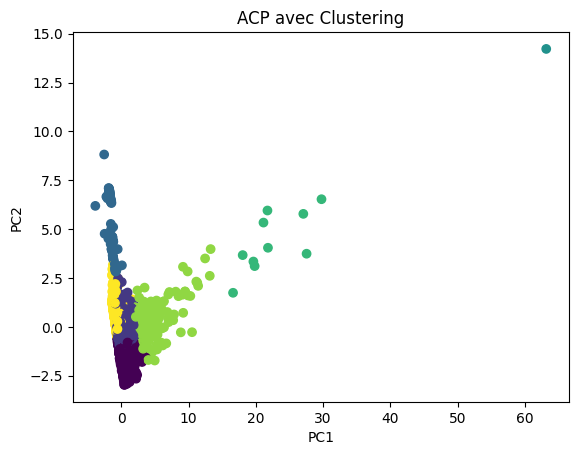

In [10]:
# Scatter plot des composantes principales avec une couleur pour chaque cluster
plt.scatter(pca_data[:,0],pca_data[:,1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ACP avec Clustering')
plt.show()

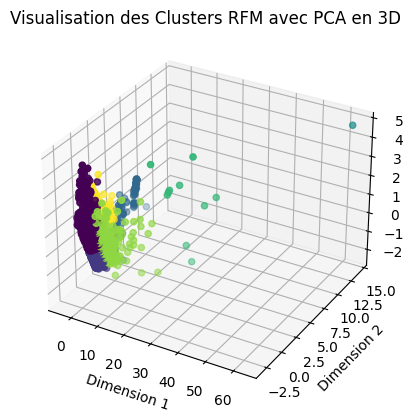

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=clusters, cmap='viridis')
ax.set_title("Visualisation des Clusters RFM avec PCA en 3D")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()


In [12]:
import numpy as np

# Obtention du nombre de points par cluster
nombre_points_par_cluster = np.bincount(kmeans.labels_)

# Affichage des résultats
for cluster, nombre_points in enumerate(nombre_points_par_cluster):
    print(f"Cluster {cluster}: {nombre_points} points")


Cluster 0: 868 points
Cluster 1: 2913 points
Cluster 2: 109 points
Cluster 3: 1 points
Cluster 4: 10 points
Cluster 5: 216 points
Cluster 6: 1703 points


In [13]:
# Filtrer les clients du cluster 4
cluster_4_clients = df[kmeans.labels_ == 4]
cluster_4_clients


,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
Customer ID,,,,,,
12748,364,35084,46933.33,0,1.126126,96.384615
12931,71,48345,71299.67,21,22.695035,680.915493
13089,247,57941,109893.24,2,2.212389,234.578947
13798,125,47251,73166.92,0,20.942982,378.008000
15061,138,73554,124961.98,3,1.210121,533.000000
15311,270,68882,111739.36,0,5.962000,255.118519
16029,125,47913,89705.47,38,8.415842,383.304000
16422,146,60940,59379.94,16,6.559572,417.397260
17841,289,36151,67186.87,1,1.606267,125.089965


In [14]:
# Filtrer les clients du cluster 3
cluster_3_clients = df[kmeans.labels_ == 3]
cluster_3_clients

,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
Customer ID,,,,,,
14911,510,141500,265757.91,0,3.190002,277.45098


Les clients des clusters 3 et 4 sont peu nombreux, en regardant leur données on s'aperçoit qu'ils commandent de grosses quantité d'articles, il s'agit de client trop spécifque qui n'ont pas été filtré lorsque l'on a éliminé les 2% avec le nombre d'artciles moyen le plus élevé. On va supprimer les clients de ces clusters. 

In [15]:
df = df.drop(cluster_4_clients.index)
df = df.drop(cluster_3_clients.index)


On relance le clustering

In [16]:
from sklearn.preprocessing import StandardScaler

# Normaliser les valeurs RFM
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(df)

In [17]:
inertias = []

for n_clusters in range(1, 30):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)

knee = KneeLocator(range(1, 30), inertias, curve="convex", direction="decreasing")
print("Nombre de clusters détecté:", knee.elbow)

Nombre de clusters détecté: 7


Après avoir testé avec 7 clusters, on décide de faire une modélisation avec 5 cluster seulement

In [18]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(rfm_normalized)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
pca_data = pca.fit_transform(rfm_normalized)


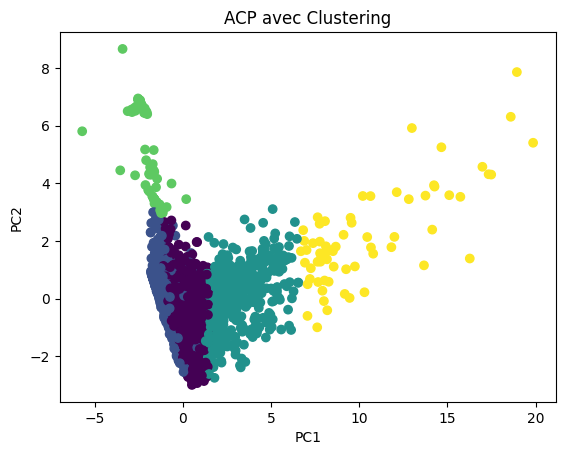

In [20]:
# Scatter plot des composantes principales avec une couleur pour chaque cluster
plt.scatter(pca_data[:,0],pca_data[:,1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ACP avec Clustering')
plt.show()

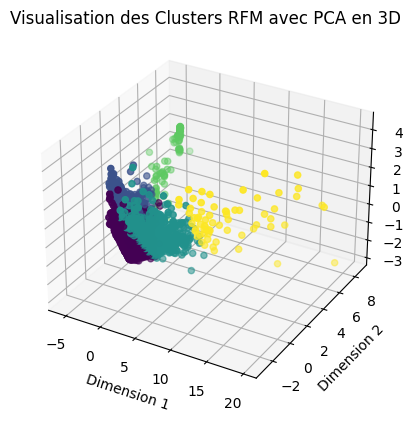

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=clusters, cmap='viridis')
ax.set_title("Visualisation des Clusters RFM avec PCA en 3D")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

In [22]:
# Obtention du nombre de points par cluster
nombre_points_par_cluster = np.bincount(kmeans.labels_)

# Affichage des résultats
for cluster, nombre_points in enumerate(nombre_points_par_cluster):
    print(f"Cluster {cluster}: {nombre_points} points")


Cluster 0: 3172 points
Cluster 1: 1896 points
Cluster 2: 567 points
Cluster 3: 109 points
Cluster 4: 65 points


In [23]:
grouped_df = df.groupby(kmeans.labels_)
cluster_stats = grouped_df.agg(['count', 'mean', 'std', 'min', lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75), 'max'])
cluster_stats

TotalInvoices                                                             \
          count       mean        std min <lambda_0> <lambda_1> <lambda_2>   
0          3172   5.705233   4.604763   1        2.0        4.0        8.0   
1          1896   2.484705   2.363482   1        1.0        2.0        3.0   
2           567  23.282187  12.479867   4       14.0       21.0       30.0   
3           109   2.220183   2.608241   1        1.0        1.0        2.0   
4            65  67.369231  40.572685  19       41.0       55.0       80.0   

       TotalQuantity                ... CancellationPercentage              \
   max         count          mean  ...             <lambda_2>         max   
0   33          3172    804.170240  ...               2.430144   44.444444   
1   28          1896    302.258439  ...               0.069061   40.000000   
2  102           567   4593.059965  ...               3.692433   41.176471   
3   22           109      5.568807  ...             100.000000  100.000000   
4  259            65  14855.461538  ...               4.946100   15.224913   

  AvgItemsPerOrder                                                  \
             count        mean         std         min  <lambda_0>   
0             3172  160.110567  111.742252    0.000000   82.000000   
1             1896  130.983343  109.450434    1.000000   57.000000   
2              567  243.614020  135.053497   14.588235  144.244709   
3              109   -4.602944   44.344794 -393.000000   -1.000000   
4               65  274.751834  137.850542   33.905263  178.066667   

                                       
   <lambda_1>  <lambda_2>         max  
0  131.690476  206.575000  688.000000  
1  100.000000  170.166667  690.000000  
2  209.964286  311.288961  684.500000  
3   -1.000000    0.000000   89.909091  
4  246.636364  340.613636  608.947368  

[5 rows x 48 columns]

In [24]:
cluster_mean = grouped_df.mean()
cluster_mean

,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
0,5.705233,804.170240,1391.947925,71.939155,2.201324,160.110567
1,2.484705,302.258439,541.883693,459.162975,2.106478,130.983343
2,23.282187,4593.059965,7903.126901,38.596120,2.798016,243.614020
3,2.220183,5.568807,-724.719174,497.577982,80.435836,-4.602944
4,67.369231,14855.461538,28482.452662,20.676923,3.654979,274.751834


In [25]:
# Création d'un dictionnaire pour stocker les plages de valeurs
ranges = {}

# Boucle sur les colonnes du DataFrame cluster_stats
for column in cluster_stats.columns.levels[0]:
    # Récupération des statistiques de la colonne
    column_stats = cluster_stats[column]
    
    # Calcul des plages en fonction des statistiques
    min_val = column_stats['min'].min()
    max_val = column_stats['max'].max()
    
    # Ajout de la plage au dictionnaire
    ranges[column] = (min_val, max_val)

# Affichage des plages de valeurs
for column, value_range in ranges.items():
    print(f"{column}: {value_range}")


TotalInvoices: (1, 259)
TotalQuantity: (-1085, 29446)
TotalPrice: (-25111.09, 57120.91)
Recency: (0, 738)
CancellationPercentage: (0.0, 100.0)
AvgItemsPerOrder: (-393.0, 690.0)


In [26]:
# Création d'un dictionnaire pour stocker les plages de valeurs
ranges = {}

# Boucle sur les colonnes du DataFrame cluster_stats
for column in cluster_stats.columns.levels[0]:
    # Récupération des statistiques de la colonne
    column_stats = cluster_stats[column]
    
    # Calcul des plages en fonction des statistiques
    min_val = column_stats['min'].min()
    max_val = column_stats['max'].max()
    
    # Ajout de la plage au dictionnaire
    ranges[column] = (min_val, max_val)

# Fonction de mise à l'échelle min-max
def scale_value(value, min_val, max_val):
    scaled_value = (value - min_val) / (max_val - min_val) * 3
    return scaled_value

# Création d'un nouveau DataFrame pour stocker les moyennes normalisées
normalized_cluster_stats = pd.DataFrame(columns=cluster_stats.columns.levels[0])

# Boucle sur les colonnes
for column in cluster_stats.columns.levels[0]:
    # Récupération des valeurs min et max de la colonne
    min_val = ranges[column][0]
    max_val = ranges[column][1]
    
    # Calcul de la moyenne normalisée de la colonne
    scaled_mean = scale_value(cluster_stats[column]['mean'], min_val, max_val)
    
    # Ajout de la moyenne normalisée au nouveau DataFrame
    normalized_cluster_stats[column] = scaled_mean

# Affichage du nouveau DataFrame avec les moyennes normalisées
normalized_cluster_stats


,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
0,0.054712,0.185631,0.966888,0.292436,0.066040,1.532162
1,0.017264,0.136313,0.935876,1.866516,0.063194,1.451477
2,0.259095,0.557931,1.204430,0.156895,0.083940,1.763474
3,0.014188,0.107160,0.889667,2.022675,2.413075,1.075892
4,0.771735,1.566322,1.955208,0.084053,0.109649,1.849728


In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Liste des clusters
clusters = normalized_cluster_stats.index.tolist()

# Création des sous-plots
fig = make_subplots(rows=2, cols=3, subplot_titles=clusters, specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}], [{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]])

# Parcours des clusters et création des radar plots pour la première ligne
for i, cluster in enumerate(clusters[:3]):
    data = normalized_cluster_stats.loc[cluster].values.tolist()
    labels = normalized_cluster_stats.columns.tolist()
    
    fig.add_trace(
        go.Scatterpolar(
            r=data,
            theta=labels,
            fill='toself',
            name=cluster
        ),
        row=1,
        col=i+1
    )

# Parcours des clusters et création des radar plots pour la deuxième ligne
for i, cluster in enumerate(clusters[3:]):
    data = normalized_cluster_stats.loc[cluster].values.tolist()
    labels = normalized_cluster_stats.columns.tolist()
    
    fig.add_trace(
        go.Scatterpolar(
            r=data,
            theta=labels,
            fill='toself',
            name=cluster
        ),
        row=2,
        col=i+1
    )

# Mise en forme du layout
for row in range(1, 3):
    for col in range(1, 4):
        fig.update_polars(
            row=row,
            col=col,
            radialaxis=dict(
                visible=True,
                range=[0, 3],  # Ajuster la plage en fonction de 0 à 3
                tickvals=[0, 1, 2, 3],  # Valeurs entières pour les ticks
                ticktext=['0', '1', '2', '3']  # Étiquettes des ticks en tant que valeurs entières
            )
        )

fig.update_layout(
    showlegend=False,
    title_text='Radar Plots par Cluster',
    height=800,  # Ajuster la hauteur de la figure
    width=1200  # Ajuster la largeur de la figure
)

# Affichage du graphique
fig.show()
